In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import special
%config InlineBackend.figure_formats = ['svg']

In [13]:
Nx = 48
Ny = 48
Nz = 120
nxyz = Nx*Ny*Nz
dx = 1
dy = 1
dz = 1
dV = dx*dy*dz
e2 = 197.3269631 / 137.035999679; # Squared charge of proton

In [14]:
xs = np.arange(0,Nx*dx,dx); xs-=(Nx//2)*dx
ys = np.arange(0,Ny*dy,dy); ys-=(Ny//2)*dy
zs = np.arange(0,Nz*dz,dz); zs-=(Nz//2)*dz
X,Y,Z = np.meshgrid(xs,ys,zs,indexing="ij")

In [15]:
def solvePoisson(rho):
    D = np.sqrt(3)*np.max([Nx*dx,Ny*dy,Nz*dz])
    e2 = 197.3269631 / 137.035999679; # Squared charge of proton
    N3 = 3*np.max([Nx,Ny,Nz])

    rho3 = np.zeros([N3,N3,N3])
    rho3[0:Nx,0:Ny,0:Nz]=rho

    kx = (2*np.pi/(N3*dx))*np.concatenate([np.arange(0,N3//2),np.arange(-N3//2,0)])
    ky = (2*np.pi/(N3*dy))*np.concatenate([np.arange(0,N3//2),np.arange(-N3//2,0)])
    kz = (2*np.pi/(N3*dz))*np.concatenate([np.arange(0,N3//2),np.arange(-N3//2,0)])
    Kx,Ky,Kz = np.meshgrid(kx,ky,kz,indexing="ij")
    K2 = Kx**2+Ky**2+Kz**2

    coul_ker = 4*np.pi*e2*(1-np.cos(D*np.sqrt(K2)))/(K2+np.finfo(np.double).eps)
    coul_ker[0,0,0] = 2*e2*np.pi*D**2

    phi3 = np.real(np.fft.ifftn(coul_ker*np.fft.fftn(rho3)))
    phi = phi3[0:Nx,0:Ny,0:Nz]
    
    return phi

In [16]:
sig = 1.87; # Standard deviation of charge distribution
numimg = 2; # Number of image charges

xoff2, yoff2, zoff2 = [0,0,0]#[0,(Ny//8)*dy,(Nz//6)*dz]#
R2 = np.sqrt((X-xoff2)**2+(Y-yoff2)**2+(Z-zoff2)**2)

gauss = np.zeros([Nx,Ny,Nz])
for imagex in range(-numimg,numimg+1):
    for imagey in range(-numimg,numimg+1):
        for imagez in range(-numimg,numimg+1):
            gauss += np.exp(-((X-xoff2+imagex*(Nx*dx))**2+
                              (Y-yoff2+imagey*(Ny*dy))**2+
                              (Z-zoff2+imagez*(Nz*dz))**2)/(2.*sig**2));
gauss *= 1/((2*np.pi*sig**2)**(3/2))
phigauss = solvePoisson(gauss)
phigaussalyt = 1*e2/(R2 + np.finfo(np.double).eps) * special.erf(R2/(np.sqrt(2)*sig)) # Analytical solution
phigaussalyt[Nx//2,Ny//2,Nz//2] = e2*np.sqrt(2/np.pi)/sig
engauss = 1838.57 # Compute in Mathematica

Total charge = 1.0000000000000002

Accuracy of Coulomb Energy: dE/E = -0.9998818523598024

Accuracy of Coulomb Potential: dV/V = 3.7390242954208074e-11



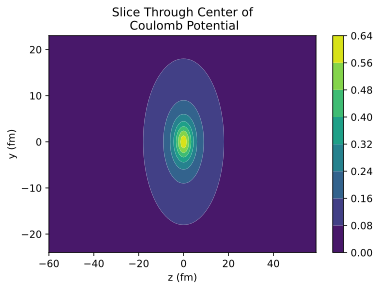

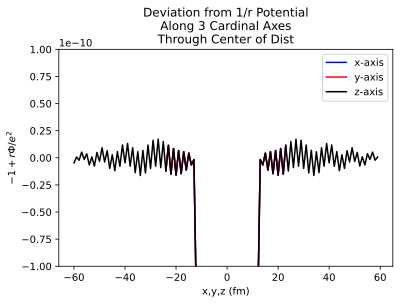

In [18]:
print(f"Total charge = {gauss.sum()*dV}")
print()
print(f"Accuracy of Coulomb Energy: dE/E = {(1/2*np.sum(gauss*phigauss)*dV-engauss)/engauss}")
print()
print(f"Accuracy of Coulomb Potential: dV/V = {np.max( np.abs(phigauss-phigaussalyt) )/np.max( np.abs(phigauss) )}")
print()

plt.contourf(phigauss[Nx//2,:,:],extent=[zs[0],zs[-1],ys[0],ys[-1]])
plt.colorbar()
plt.title("Slice Through Center of\n Coulomb Potential")
plt.xlabel("z (fm)")
plt.ylabel("y (fm)")
plt.show()

plt.plot(xs,-1+(R2*phigauss)[:,Ny//2+yoff2//dy,Nz//2+zoff2//dz]/e2,"b",label="x-axis")
#plt.show()
plt.plot(ys,-1+(R2*phigauss)[Nx//2,:,Nz//2+zoff2//dz]/e2,"r",label="y-axis")
#plt.show()
plt.plot(zs,-1+(R2*phigauss)[Nx//2,Ny//2+yoff2//dy,:]/e2,"k",label="z-axis")
plt.ylim([-1e-10,1e-10])
plt.xlabel("x,y,z (fm)")
plt.ylabel("$-1 + r \Phi/e^2$")
plt.title("Deviation from 1/r Potential\nAlong 3 Cardinal Axes\nThrough Center of Dist")
#plt.vlines(xoff2,-1e-10,1e-10,"gray")
#plt.vlines(yoff2,-1e-10,1e-10,"gray")
#plt.vlines(zoff2,-1e-10,1e-10,"gray")
plt.legend()
plt.show()